# MNIST Classification with Brevitas Quantization-Aware Training 

In this notebook, we show how to use [Brevitas](https://github.com/Xilinx/brevitas) to perform quantization-aware training on the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, using a fast FHE-friendly model with a low bit-width accumulator of 6-bits. Then, we show how the Virtual Library can be used to finetune parameters and find the best setting, before finally checking computations in FHE.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Concrete-Numpy
from concrete.numpy.compilation import Configuration

# The QAT model
from model import MNISTQATModel  # pylint: disable=no-name-in-module
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm

# Concrete-ML
from concrete.ml.torch.compile import compile_brevitas_qat_model

Here are the classical functions to train and test the model.

In [2]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """Train the model."""

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if epoch % 4 == 0 and batch_idx % 500 == 0:
            print(
                f"Train Epoch: {epoch + 1} [{batch_idx}/{len(train_loader.dataset) // len(data)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]{'':5}"
                f"\tLoss: {loss.item():.6f}"
            )

In [3]:
def test(model, device, test_loader, epoch, criterion):
    """Test the model."""

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, disable=epoch % 4 != 0):
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if epoch % 4 == 0:
        print(
            f"Test set: Average loss: {test_loss:.4f}, "
            "Accuracy: "
            f"{correct}/{len(test_loader.dataset)} "
            f"({100.0 * correct / len(test_loader.dataset):.0f}%)"
        )

    return test_loss

In [4]:
def manage_dataset(train_kwargs, test_kwargs):
    """Get training and test parts of MNIST dataset."""

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Lambda(torch.flatten),
        ]
    )

    # Manage datasets
    dataset1 = datasets.MNIST("./data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("./data", train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

The following function is used to test the model, it can be done either with the Virtual Library (i.e., without encryption) or in FHE. 

Checking things in VL is a very good habit to have within Concrete-ML since it allows to see the effect of the quantization on the accuracy, as well as to check the maximal bit-width of intermediate values, without having to wait as long as when things are computed in FHE.

In [5]:
def compile_and_test(
    model,
    use_virtual_lib,
    test_data,
    test_data_length,
    test_target,
    show_mlir,
    current_index,
):
    # Compile the QAT model and test
    configuration = Configuration(
        enable_unsafe_features=True,  # This is for our tests only, never use that in prod
        use_insecure_key_cache=True,  # This is for our tests only, never use that in prod
        insecure_key_cache_location="/tmp/keycache",
    )

    if use_virtual_lib:
        print(f"\n{current_index}. Compiling with the Virtual Library")
    else:
        print(f"\n{current_index}. Compiling in FHE")

    q_module = compile_brevitas_qat_model(
        model,
        test_data,
        configuration=configuration,
        use_virtual_lib=use_virtual_lib,
        show_mlir=show_mlir,
    )

    # Check max bit-width
    max_bit_width = q_module.forward_fhe.graph.maximum_integer_bit_width()

    if max_bit_width > 8:
        raise Exception(
            f"Too large bit-width ({max_bit_width}): training this network resulted in an "
            "accumulator size that is too large. Possible solutions are:"
            "    - this network should, on average, have 8bit accumulators. In your case an unlucky"
            f"initialization resulted in {max_bit_width} accumulators. You can try to train the "
            "network again"
            "    - reduce the sparsity to reduce the number of active neuron connexions"
            "    - if the weight and activation bitwidth is more than 2, you can try to reduce one "
            "or both to a lower value"
        )

    # Check the accuracy
    if use_virtual_lib:
        print(
            f"\n{current_index + 1}. Checking accuracy with the Virtual Library "
            f"(length {test_data_length})"
        )
    else:
        print(f"\n{current_index + 1}. Checking accuracy in FHE (length {test_data_length})")

    # Key generation
    if not use_virtual_lib:
        q_module.forward_fhe.keygen()

    correct_fhe = 0
    idx = 0

    # Reduce the test data, since the computation is very slow in FHE
    reduced_test_data = test_data[0:test_data_length, :]

    for idx, im in enumerate(tqdm(reduced_test_data)):
        target_np = test_target[idx]
        q_data = q_module.quantize_input(im)
        q_data = np.expand_dims(q_data, 0).astype(np.int64)

        prediction = (
            q_module.forward_fhe.simulate(q_data)
            if use_virtual_lib
            else q_module.forward_fhe.encrypt_run_decrypt(q_data)
        )
        prediction = q_module.dequantize_output(prediction)

        if np.argmax(prediction) == target_np:
            correct_fhe += 1

    # Final accuracy
    return correct_fhe, reduced_test_data.shape[0], max_bit_width

## Settings

Here, the user can change some settings. The most important ones are:
- epochs: how many epochs during the training
- sparsity: to define the number of active neurons in layers; make this value smaller and there will be less active neurons
- quantization_bits: the number of bits during quantization. The larger the more accurate, but also the faster we are above the limits of Concrete-ML in term of maximal bitwidth
- do_training: whether we do the training. If not, we use the previously saved ONNX model

In [6]:
# Options: the most important ones
epochs = 20
sparsity = 4
quantization_bits = 2
do_training = True

# Options: can be changed
lr = 0.02
gamma = 0.33
test_data_length_reduced = 2  # This is notably the length of the computation in FHE
test_data_length_full = 10000

# Options: no real reason to change
show_mlir = False
batch_size = 32
test_batch_size = 32
use_cuda_if_available = True
seed = None
criterion = nn.CrossEntropyLoss()

Seeding if we want to, to try to make everything as reproducible as possible.

In [7]:
# Seeding
if seed is None:
    seed = np.random.randint(0, 2**32 - 1)

print(f"\nUsing seed {seed}\n")
torch.manual_seed(seed);


Using seed 3637302257



Settings few things for the training.

In [8]:
# Training and test arguments
train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}

# Cuda management
use_cuda = torch.cuda.is_available() and use_cuda_if_available
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

print(f"\nUsing {device} device\n")


Using cuda device



Managing the MNIST data set, and splitting it into a train and testing set.

In [9]:
# Manage dataset
train_loader, test_loader = manage_dataset(train_kwargs, test_kwargs)
img_size = train_loader.dataset.data[0].shape[0]

### Defining the model

The model is defined in `model.py`. You may want to have a look to this file to see how things work in Brevitas or apply few changes here, to see what are the effects on the QAT training.

In [10]:
# Model definition
model = MNISTQATModel(quantization_bits, quantization_bits)
model = model.to(device)
model.prune(sparsity, True)

### Running the training

Below, we run the quantization-aware training, which can be quite slow.

Performing MNIST task with 2-bits in quantization and a sparsity of 4

1. Training
Train Epoch: 1 [0/1875 (0%)]     	Loss: 8.869301
Train Epoch: 1 [500/1875 (27%)]     	Loss: 0.502103
Train Epoch: 1 [1000/1875 (53%)]     	Loss: 0.554580
Train Epoch: 1 [1500/1875 (80%)]     	Loss: 0.767699


100%|██████████| 313/313 [00:09<00:00, 34.44it/s]

Test set: Average loss: 0.0143, Accuracy: 8436/10000 (84%)


Train Epoch: 5 [0/1875 (0%)]     	Loss: 0.174913
Train Epoch: 5 [500/1875 (27%)]     	Loss: 0.215498
Train Epoch: 5 [1000/1875 (53%)]     	Loss: 0.456621
Train Epoch: 5 [1500/1875 (80%)]     	Loss: 0.134158


100%|██████████| 313/313 [00:03<00:00, 87.48it/s] 

Test set: Average loss: 0.0093, Accuracy: 9064/10000 (91%)


Train Epoch: 9 [0/1875 (0%)]     	Loss: 0.388931
Train Epoch: 9 [500/1875 (27%)]     	Loss: 0.102727
Train Epoch: 9 [1000/1875 (53%)]     	Loss: 0.461383
Train Epoch: 9 [1500/1875 (80%)]     	Loss: 0.066703


100%|██████████| 313/313 [00:01<00:00, 167.07it/s]


Test set: Average loss: 0.0090, Accuracy: 9126/10000 (91%)
Train Epoch: 13 [0/1875 (0%)]     	Loss: 0.499372
Train Epoch: 13 [500/1875 (27%)]     	Loss: 0.508643
Train Epoch: 13 [1000/1875 (53%)]     	Loss: 0.265678
Train Epoch: 13 [1500/1875 (80%)]     	Loss: 0.332836


100%|██████████| 313/313 [00:01<00:00, 243.72it/s]

Test set: Average loss: 0.0084, Accuracy: 9250/10000 (92%)


Train Epoch: 17 [0/1875 (0%)]     	Loss: 0.505016
Train Epoch: 17 [500/1875 (27%)]     	Loss: 0.269431
Train Epoch: 17 [1000/1875 (53%)]     	Loss: 0.349189
Train Epoch: 17 [1500/1875 (80%)]     	Loss: 0.139445


100%|██████████| 313/313 [00:01<00:00, 269.76it/s]

Test set: Average loss: 0.0107, Accuracy: 8949/10000 (89%)



2. Exporting to ONNX and saving the Brevitas model


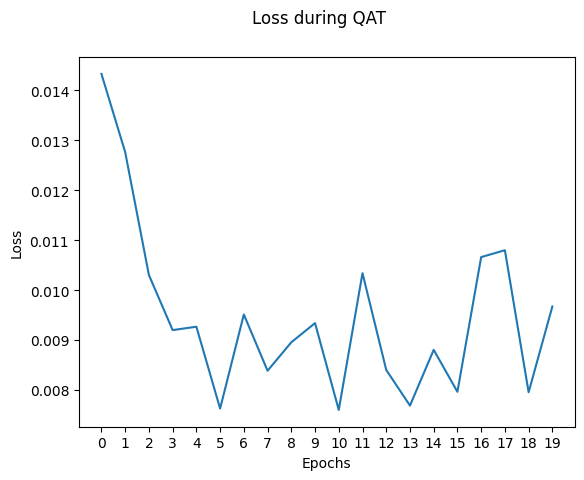

In [11]:
# Training part
print(
    f"Performing MNIST task with {quantization_bits}-bits in quantization and a "
    f"sparsity of {sparsity}"
)

if do_training:
    print("\n1. Training")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    loss_values = []

    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, epoch, criterion)
        cur_loss = test(model, device, test_loader, epoch, criterion)

        scheduler.step()

        loss_values.append(cur_loss)

    model.prune(sparsity, False)

    # Plot the loss
    fig = plt.figure()
    plt.plot(loss_values)
    fig.suptitle("Loss during QAT")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(range(len(loss_values)))

    # Export to ONNX
    print("\n2. Exporting to ONNX and saving the Brevitas model")
    inp = torch.rand((1, img_size * img_size)).to(device)
    torch.onnx.export(model, inp, "mnist.qat.onnx", opset_version=14)
    torch.save(model.state_dict(), "state_dict.pt")
else:
    print("\n1. Loading pre-trained model")

To avoid the training phase, you can directly load the pre-trained model by setting `do_training = False`.

In [12]:
checkpoint = torch.load("state_dict.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

We prepare the ground truth, for final check of the model.

In [13]:
# Prepare tests
test_data = np.zeros((len(test_loader.dataset), img_size * img_size))
test_target = np.zeros((len(test_loader.dataset), 1))
idx = 0

for data, target in tqdm(test_loader):
    target_np = target.cpu().numpy()
    for idx_batch, im in enumerate(data.numpy()):
        test_data[idx] = im
        test_target[idx] = target_np[idx_batch]
        idx += 1

100%|██████████| 313/313 [00:00<00:00, 344.34it/s]


### Measuring accuracy in VL and FHE

Finally, we measure:
- accuracy in VL for the full test set
- accuracy in VL for the reduced test set
- accuracy in FHE for the reduced test set   

and we check that accuracy in VL and in FHE are equivalent on the reduced test set. 

Running FHE computations on a too large reduced test set may be prohibitive since we're 100% on CPU for the time being. Later, we'll have HW accelerators, to make these computations several order of magnitude faster. 

In [14]:
# Test in the VL and in FHE
accuracy = {}
current_index = 3

for use_virtual_lib, use_full_dataset in [(True, True), (True, False), (False, False)]:
    test_data_length = test_data_length_full if use_full_dataset else test_data_length_reduced

    correct_fhe, test_data_shape_0, max_bit_width = compile_and_test(
        model.cpu(),
        use_virtual_lib,
        test_data,
        test_data_length,
        test_target,
        show_mlir,
        current_index,
    )

    current_index += 2
    current_accuracy = correct_fhe / test_data_shape_0

    print(
        f"Accuracy in {'VL' if use_virtual_lib else 'FHE'} with length {test_data_length}: "
        f"{correct_fhe}/{test_data_shape_0} = "
        f"{current_accuracy:.4f}, in {max_bit_width}-bits"
    )

    if (use_virtual_lib, use_full_dataset) == (True, True):
        accuracy["VL full"] = current_accuracy
    elif (use_virtual_lib, use_full_dataset) == (True, False):
        accuracy["VL short"] = current_accuracy
    else:
        assert (use_virtual_lib, use_full_dataset) == (False, False)
        accuracy["FHE short"] = current_accuracy


3. Compiling with the Virtual Library

4. Checking accuracy with the Virtual Library (length 10000)


100%|██████████| 10000/10000 [00:18<00:00, 535.81it/s]


Accuracy in VL with length 10000: 9034/10000 = 0.9034, in 6-bits

5. Compiling with the Virtual Library

6. Checking accuracy with the Virtual Library (length 2)


100%|██████████| 2/2 [00:00<00:00, 432.11it/s]

Accuracy in VL with length 2: 2/2 = 1.0000, in 6-bits

7. Compiling in FHE



8. Checking accuracy in FHE (length 2)


100%|██████████| 2/2 [00:19<00:00,  9.73s/it]

Accuracy in FHE with length 2: 2/2 = 1.0000, in 6-bits


In [15]:
# Check that accuracy in FHE and in VL is the same
assert (
    accuracy["VL short"] == accuracy["FHE short"]
), "Error, accuracy in VL and in FHE are not the same"

# Check that accuracy is random-looking
assert accuracy["VL full"] > 0.8, "Error, accuracy is too bad"

### Conclusion

We've shown how to train a model with Brevitas in quantization-aware training and how easy it is to obtain a satisfactory accuray of 92% even if it is lower than the state-of-the-art on cleartexts. 

Brevitas is not the only third-party package one can use for QAT. Other examples with other frameworks will certainly be added in our repository.